In [ ]:
##############################################################################################
#                              phase1_analysis_plots.ipynb
##############################################################################################
# Purpose: Allows user to create 3x3, 5x5 confusion matrices, as well as reliability diagrams
# Usage: Run cells as needed
# Author: Alexandros Pratsos (some code borrowed from Andrew Phillips, Elizabeth Warrick
# Date: 07/29/24
##############################################################################################

In [230]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.calibration import calibration_curve

df = pd.read_csv('ntn_data/ntn_data_7-10-24_retirement=40.csv')
df.sort_values(by=['subject_id'])

df_q = pd.read_csv('name-that-neutrino-mc-revised-5-6-24.csv')
df_q.sort_values(by=['subject_id'])


def getUncertaintyLabels(matrix_df):
    # This function is copied from Andrew/Elizabeth's Githubs
    # Used to make labels for confusion matrices, formatting code
    labels = []
    nrows, ncols = matrix_df.shape
    for i in range(0,ncols):
        col_sum = matrix_df.iloc[:,i].sum()
        for k in range(0,nrows):
            val = matrix_df.iloc[k,i]
            n_val = (val/col_sum.astype(float))*100
            val_percent_round = "%.1f" % n_val
            lab_n = '%.1f%%'%n_val
            lab_v = '%d/%d'%(val,col_sum)
            lab='%.1f\%%\n%d/%d' % (n_val, val, col_sum)
            lab='%.1f%%\n%d/%d' % (n_val, val, col_sum)
            labelc= str(lab_n)+"\n"+str(lab_v)
            label = f"{str(lab_n)} {str(lab_v)}"
            labels.append(str(lab))
    labels_array = np.asarray(labels)
    labels_val = labels_array.reshape(ncols, nrows)
    labels_new = labels_val.T
    return labels_new
    

def getUncertaintyLabelsIncompleteData(matrix_df, col_totals):
    # My customization of prior function which allows user to create labels for "incomplete" 3x3 matrices
    labels = []
    nrows, ncols = matrix_df.shape
    for i in range(0,ncols):
        #col_sum = matrix_df.iloc[:,i].sum()
        col_sum = col_totals[i]
        for k in range(0,nrows):
            val = matrix_df.iloc[k,i]
            #n_val = (val/col_sum.astype(float))*100
            n_val = (val/col_sum)*100
            val_percent_round = "%.1f" % n_val
            lab_n = '%.1f%%'%n_val
            lab_v = '%d/%d'%(val,col_sum)
            lab='%.1f\%%\n%d/%d' % (n_val, val, col_sum)
            lab='%.1f%%\n%d/%d' % (n_val, val, col_sum)
            labelc= str(lab_n)+"\n"+str(lab_v)
            label = f"{str(lab_n)} {str(lab_v)}"
            labels.append(str(lab))
    labels_array = np.asarray(labels)
    labels_val = labels_array.reshape(ncols, nrows)
    labels_new = labels_val.T
    return labels_new

def get_classifications(df: pd.DataFrame, user_threshold_agreement: float):
    # My original get_classifications method (might be better named get_classifications_3x3)
    # Returns an nx3 "array" : user classification, dnn classification, old_mc classification
    # Was used to recreate 3x3 confusion matrices from Prof. Love's paper
    classifications = []
    categories = [2, 3, 4]
    for i in range(len(df['new_truth_classification'])):
        user = df['user_classification'][i]
        dnn = df['dnn_classification'][i]
        val = df['new_truth_classification'][i]
        old_val = df['old_truth_classification'][i]
        if (user != dnn) and (user in categories or dnn in categories) and (df['user agreement'][i] >= user_threshold_agreement) and (old_val in categories):
            classifications.append([user, dnn, old_val])
        
    return classifications

def get_classifications_5x5(df: pd.DataFrame, dnn_threshold_bottom: float, dnn_threshold_top: float,  q_threshold_bottom: float, q_threshold_top: float, user_threshold_agreement=.55):
    # The updated and more applicable get_classifications method
    # Returns a 6xn matrix :  user classification, dnn classification, new_mc classification, dnn_confidence, user_agreement, q_ratio
    classifications = []
    #categories = [2, 3, 4]
    for i in range(len(df['new_truth_classification'])):
        user = df['user_classification'][i]
        dnn = df['dnn_classification'][i]
        val = df['new_truth_classification'][i]
        dnn_conf = max(df['pred_skim'][i], df['pred_cascade'][i], df['pred_tgtrack'][i], df['pred_starttracks'][i], df['pred_stoptrack'][i])
        user_conf = df['user agreement'][i]
        q_ratio = float(df_q['signal_charge'][i]) / float((df_q['signal_charge'][i]) + float(df_q['bg_charge'][i]))
        #old_val = df['old_truth_classification'][i]
        if dnn_conf >= dnn_threshold_bottom and dnn_conf <= dnn_threshold_top and user_conf >= user_threshold_agreement and (q_ratio >= q_threshold_top or q_ratio <= q_threshold_bottom):
            classifications.append([user, dnn, val, dnn_conf, user_conf, q_ratio])
        
    return classifications
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4271 entries, 0 to 4270
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subject_set_id            4271 non-null   int64  
 1   subject_id                4271 non-null   int64  
 2   event_id                  4271 non-null   int64  
 3   total_class_count         4271 non-null   int64  
 4   pred_skim                 4271 non-null   float64
 5   pred_cascade              4271 non-null   float64
 6   pred_tgtrack              4271 non-null   float64
 7   pred_starttracks          4271 non-null   float64
 8   pred_stoptrack            4271 non-null   float64
 9   dnn_classification        4271 non-null   int64  
 10  user_max_votes            4271 non-null   int64  
 11  user agreement            4271 non-null   float64
 12  user_classification       4271 non-null   int64  
 13  old_truth_classification  4271 non-null   int64  
 14  new_trut

In [3]:
#Run this cell to obtain the classifications before creating 3x3 confusion matrices

classifications = get_classifications(df, 0.55)
print("# of classifications:", len(classifications))

types = ['Through-Going\nTrack','Starting\nTrack','Stopping\nTrack']

user_class = [row[0] for row in classifications]
dnn_class = [row[1] for row in classifications]
mc_class = [row[2] for row in classifications]

print(mc_class[:20])


# of classifications: 172
[3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 2, 2]


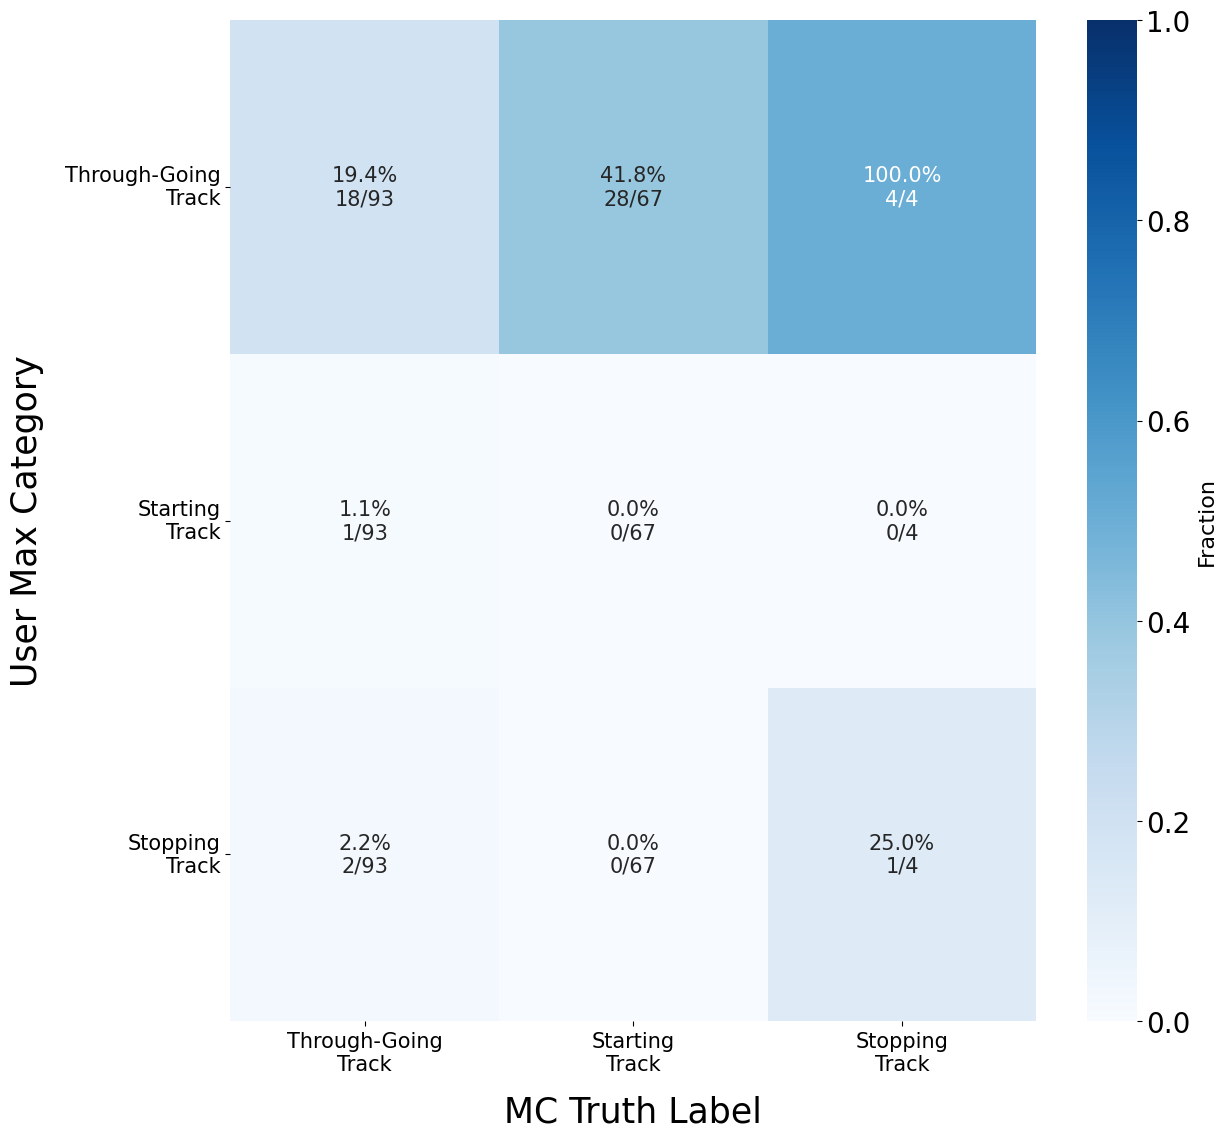

In [231]:
#code borrowed and slightly modified from E. Warrick / Andrew P. in order to make 3x3 instead of 5x5 conf. matrices
#This cell creates 3x3 matrix for User vs MC

confusion_matrix_user_truth_norm = pd.crosstab(user_class, mc_class, rownames=['User Max Category'], colnames=['MC Truth Label'], margins=False,normalize='columns')
# confusion_matrix_user_truth_norm = confusion_matrix_user_truth_norm.drop(columns = [0, 1])
confusion_matrix_user_truth_norm = confusion_matrix_user_truth_norm.iloc[2:]

confusion_matrix_user_truth = pd.crosstab(user_class, mc_class, rownames=['User Max Category'], colnames=['MC Truth Label'], margins=False)
col_totals = list(confusion_matrix_ml_truth.sum(axis = 'rows'))
# confusion_matrix_user_truth = confusion_matrix_user_truth.drop(columns = [0, 1])
confusion_matrix_user_truth = confusion_matrix_user_truth.iloc[2:]

fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(confusion_matrix_user_truth_norm, annot=getUncertaintyLabelsIncompleteData(confusion_matrix_user_truth, col_totals), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Fraction',fontsize=16)
#plt.show()
plt.ylabel('User Max Category',fontsize=25,labelpad=15)
plt.xlabel('MC Truth Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(3)+0.5,types,
        rotation=0, fontsize="15", va="center")
plt.xticks(np.arange(3)+0.5,types,
        rotation=0, fontsize="15")

plt.savefig('User_vs_MC_55_disagree_ret20_oldval.png', bbox_inches='tight')

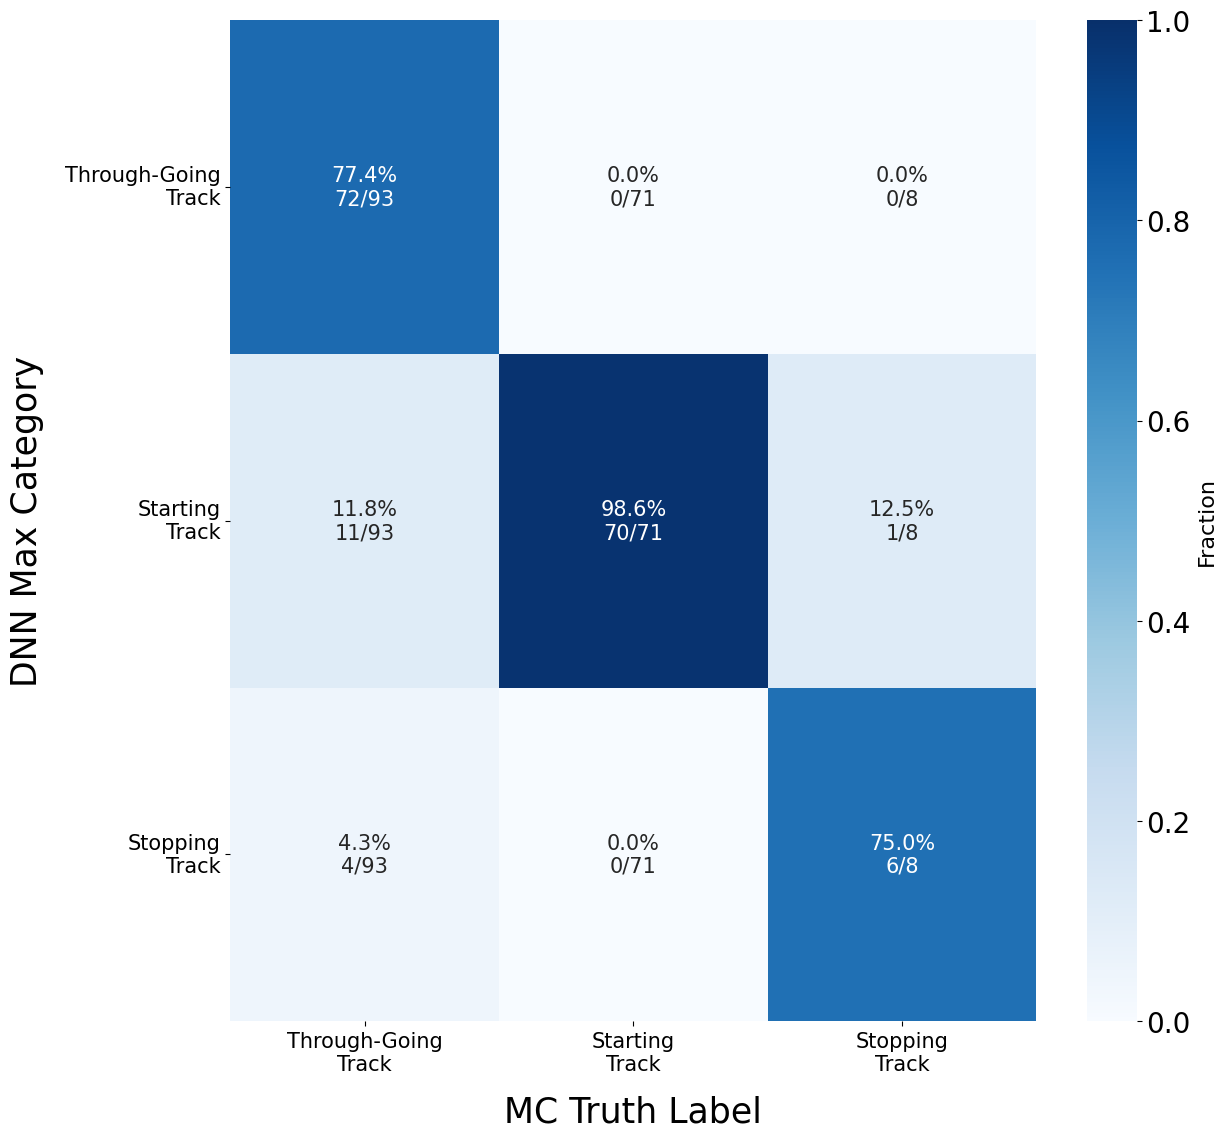

In [232]:
#This cell creates 3x3 matrix for DNN vs MC

confusion_matrix_ml_truth_norm = pd.crosstab(dnn_class, mc_class, rownames=['DNN Max Category'], colnames=['MC Truth Label'], margins=False,normalize='columns')
# confusion_matrix_ml_truth_norm = confusion_matrix_ml_truth_norm.drop(columns = [0, 1])
confusion_matrix_ml_truth_norm = confusion_matrix_ml_truth_norm.iloc[2:]

confusion_matrix_ml_truth = pd.crosstab(dnn_class, mc_class, rownames=['DNN Max Category'], colnames=['MC Truth Label'], margins=False)
col_totals = list(confusion_matrix_ml_truth.sum(axis = 'rows'))
# confusion_matrix_ml_truth = confusion_matrix_ml_truth.drop(columns = [0, 1])
confusion_matrix_ml_truth = confusion_matrix_ml_truth.iloc[2:]

fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(confusion_matrix_ml_truth_norm, annot=getUncertaintyLabelsIncompleteData(confusion_matrix_ml_truth, col_totals), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Fraction',fontsize=16)
#plt.show()
plt.ylabel('DNN Max Category',fontsize=25,labelpad=15)
plt.xlabel('MC Truth Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(3)+0.5,types,
        rotation=0, fontsize="15", va="center")
plt.xticks(np.arange(3)+0.5,types,
        rotation=0, fontsize="15")

plt.savefig('DNN_vs_MC_55_disagree_ret20_oldval.png', bbox_inches='tight')

In [116]:
def make_conf_matrix(y_data: list, x_data: list, y_title: str, x_title: str, size: tuple, types: list[str], filename: str, class_func= get_classifications_5x5):
    
    fig, ax = plt.subplots(figsize=(13,13))
    
    confusion_matrix_truth_norm = pd.crosstab(y_data, x_data, rownames=[y_title], colnames=[x_title], margins=False,normalize='columns')
    # confusion_matrix_ml_truth_norm = confusion_matrix_ml_truth_norm.drop(columns = [0, 1])
    
    confusion_matrix_truth = pd.crosstab(y_data, x_data, rownames=[y_title], colnames=[x_title], margins=False)


    if class_func is get_classifications:
        confusion_matrix_truth_norm = confusion_matrix_ml_truth_norm.iloc[2:]
        
        col_totals = list(confusion_matrix_ml_truth.sum(axis = 'rows'))
        # confusion_matrix_ml_truth = confusion_matrix_ml_truth.drop(columns = [0, 1])
        confusion_matrix_ml_truth = confusion_matrix_ml_truth.iloc[2:]
        
        ax = sns.heatmap(confusion_matrix_truth_norm, annot=getUncertaintyLabelsIncompleteData(confusion_matrix_truth, col_totals), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
    else:
        ax = sns.heatmap(confusion_matrix_truth_norm, annot=getUncertaintyLabels(confusion_matrix_truth), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
        
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_ylabel('Fraction',fontsize=16)
    #plt.show()
    plt.ylabel(y_title, fontsize=25,labelpad=15)
    plt.xlabel(x_title, fontsize=25,labelpad=15)
    plt.yticks(np.arange(size[0])+0.5,types,
            rotation=0, fontsize="15", va="center")
    plt.xticks(np.arange(size[1])+0.5,types,
            rotation=0, fontsize="15")
    
    plt.savefig(os.path.join(os.getcwd(), '5x5 Plots', filename), bbox_inches='tight')

In [226]:
#This cell actually generates the classifications that are later used to create matrices and reliability diagrams

classifications = get_classifications_5x5(df, 0, 1, .5, .5, 0)

print("# of classifications:", len(classifications))

types = ['Skimming','Cascade','Through-Going\nTrack','Starting\nTrack','Stopping\nTrack']

user_class = [row[0] for row in classifications]
dnn_class = [row[1] for row in classifications]
mc_class = [row[2] for row in classifications]
dnn_conf = [row[3] for row in classifications]
user_conf = [row[4] for row in classifications]

# of classifications: 4271


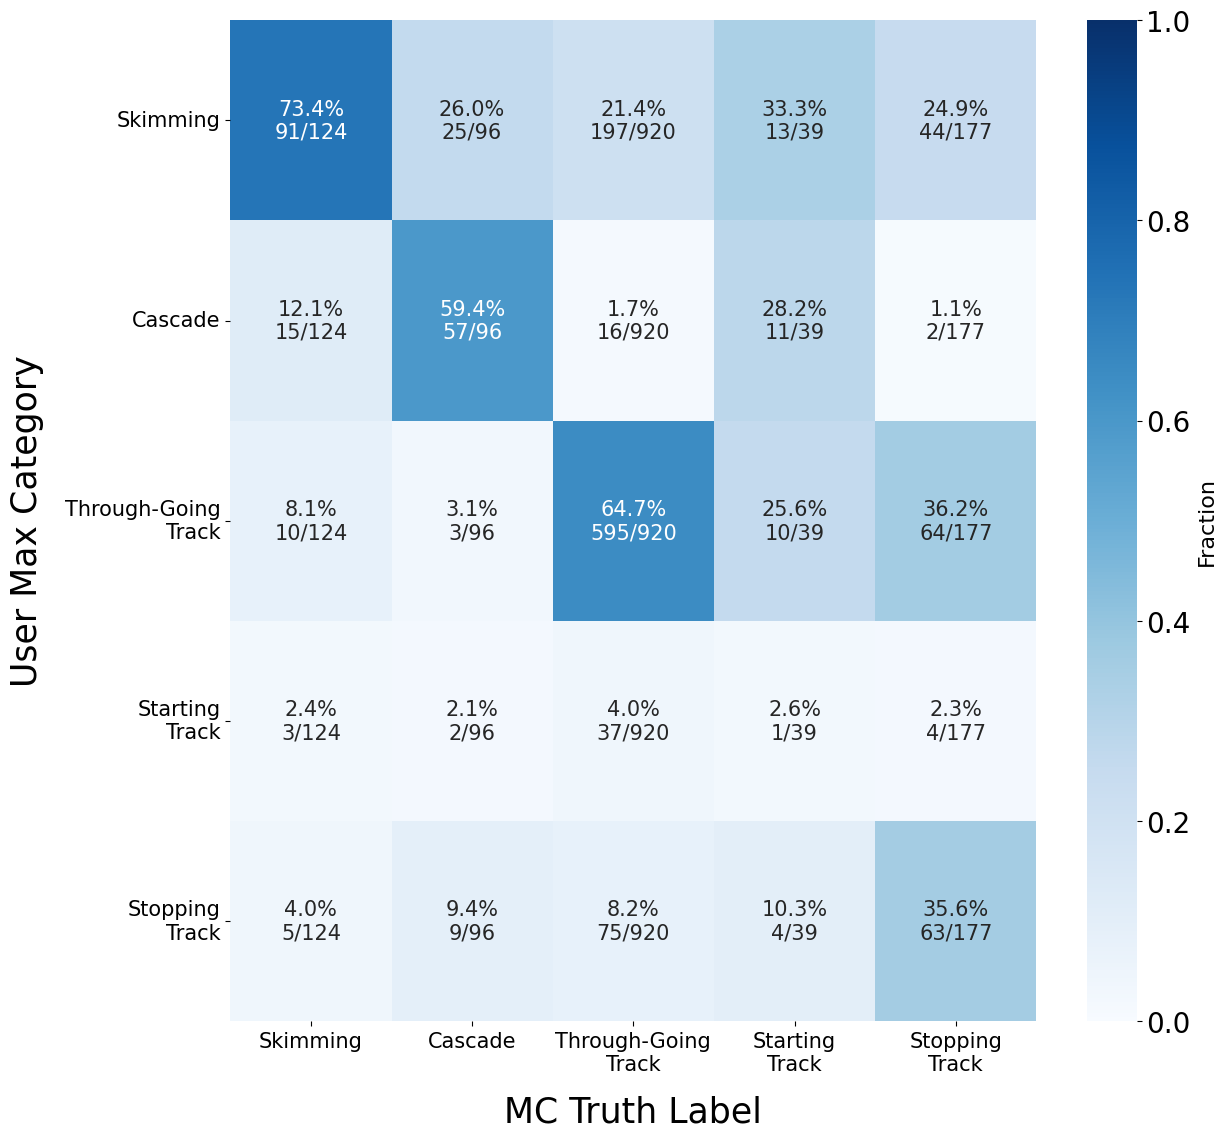

In [216]:
make_conf_matrix(user_class, mc_class, 'User Max Category', 'MC Truth Label', (5, 5), types, '5x5_User_vs_MC_0to75_0user.png')

In [328]:
classifications.sort(key = lambda x: x[3])

In [322]:
len(classifications)

4271

In [225]:
#This cell could be useful if trying to do analysis on different classification types

indeces = [[], [], [], [], []]

for i in range(len(classifications)):
    indeces[classifications[i][2]].append(i)

event = 4

user_class = [classifications[val][0] for val in indeces[event]]
dnn_class = [classifications[val][1] for val in indeces[event]]
mc_class = [classifications[val][2] for val in indeces[event]]
dnn_conf = [classifications[val][3] for val in indeces[event]]
user_conf = [classifications[val][4] for val in indeces[event]]

#print(len(indeces[0]) + len(indeces[1]) + len(indeces[2]) + len(indeces[3]) + len(indeces[4]))

count0 = len(indeces[0])
count1 = len(indeces[1])
count2 = len(indeces[2])
count3 = len(indeces[3])
count4 = len(indeces[4])


924
683
1997
311
356


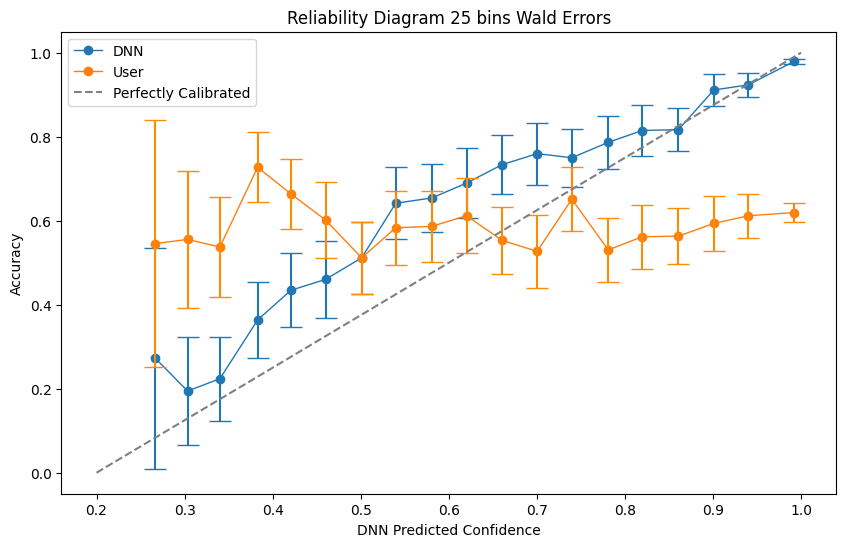

In [232]:
#This cell is an implementation of scikit.calibration.calibration_curve
#I use calibration_curve to create the reliability diagrams and also add some customization for bin number, bin type, and errorbar type
#Note that 'Wald' is recommended and is also called a 'normal approximation' for errors

types = ['Skimming','Cascade','Through-Going Track','Starting Track','Stopping Track']


predicted_labels_dnn = np.array(dnn_class)
predicted_labels_user = np.array(user_class)

true_labels = np.array(mc_class)

predicted_confidences_dnn = np.array(dnn_conf)
predicted_confidences_user = np.array(user_conf)

n_bins = 25
z = 1.96
strategy = 'uniform'
interval_type = 'Wald'

if strategy == "quantile":  # Determine bin edges by distribution of data
        quantiles = np.linspace(0, 1, n_bins + 1)
        bins = np.percentile(predicted_confidences_dnn, quantiles * 100)
elif strategy == "uniform":
    bins = np.linspace(0.0, 1.0, n_bins + 1)

binids = np.searchsorted(bins[1:-1], predicted_confidences_dnn)

bin_sums = np.bincount(binids, weights=predicted_confidences_dnn, minlength=len(bins))
bin_true_dnn = np.bincount(binids, weights= (predicted_labels_dnn == true_labels), minlength=len(bins))
bin_true_user = np.bincount(binids, weights= (predicted_labels_user == true_labels), minlength=len(bins)) 
bin_total = np.bincount(binids, minlength=len(bins))

nonzero = bin_total != 0
# print("bin_sums: ", (bin_sums[nonzero]))
# print("bin_true_user: ", (bin_true_user[nonzero]))
# print("bin_false_user: ", (bin_total[nonzero] - bin_true_user[nonzero]))
# print('bin_total: ', bin_total[nonzero]) 
bin_false_user = bin_total - bin_true_user
bin_false_dnn = bin_total - bin_true_dnn

if interval_type == 'Wald':
    user_errs = z / np.sqrt(bin_total[nonzero]) * np.sqrt(bin_true_user[nonzero] * bin_false_user[nonzero] / (bin_total[nonzero] ** 2))
    dnn_errs  = z / np.sqrt(bin_total[nonzero]) * np.sqrt(bin_true_dnn[nonzero]  * bin_false_dnn[nonzero]  / (bin_total[nonzero] ** 2))
if interval_type == 'Naoko':
    user_errs = bin_true_user[nonzero] / (bin_total[nonzero] ** 1.5)
    dnn_errs = bin_true_dnn[nonzero] / (bin_total[nonzero] ** 1.5)
if interval_type == 'Wilson':
    user_t1 = (bin_true_user[nonzero] + .5 * z * z) / (bin_total[nonzero] + z * z)
    user_t2 = (z / (bin_total[nonzero] + z * z)) 
    user_t3 = np.sqrt((bin_true_user[nonzero] * bin_false_user[nonzero] / bin_total[nonzero]) + (z*z/4.0))
    user_errs = user_t1 + user_t2 * user_t3 - (bin_true_user[nonzero] / bin_total[nonzero])
    dnn_t1 = (bin_true_dnn[nonzero] + .5 * z * z) / (bin_total[nonzero] + z * z)
    dnn_t2 = (z / (bin_total[nonzero] + z * z)) 
    dnn_t3 = np.sqrt((bin_true_dnn[nonzero] * bin_false_dnn[nonzero] / bin_total[nonzero]) + (z*z/4.0))
    dnn_errs = dnn_t1 + dnn_t2 * dnn_t3 - (bin_true_dnn[nonzero] / bin_total[nonzero])

# print('user_errs: ', user_errs)
prob_true_dnn, prob_pred_dnn = calibration_curve((predicted_labels_dnn == true_labels), predicted_confidences_dnn, n_bins=n_bins, strategy = strategy)
prob_true_user, prob_pred_user = calibration_curve((predicted_labels_user == true_labels), predicted_confidences_dnn, n_bins=n_bins, strategy = strategy)


#------------------------------------------------------------------------------------------------------------------------------------------------------
#Plotting Code

plt.figure(figsize=(10, 6))
plt.plot(prob_pred_dnn, prob_true_dnn, marker='o', linewidth=1, label='DNN')
plt.errorbar(prob_pred_dnn, prob_true_dnn, yerr = dnn_errs, fmt='none', capsize = 8)

plt.plot(prob_pred_user, prob_true_user, marker='o', linewidth=1, label='User')#, color = 'Orange')
plt.errorbar(prob_pred_dnn, prob_true_user, yerr = user_errs, fmt='none', capsize = 8, ecolor = 'darkorange')
plt.plot([0.2, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('DNN Predicted Confidence')
plt.ylabel('Accuracy')
#plt.title(types[event] + ' Reliability Diagram')
plt.title('Reliability Diagram %d bins'% n_bins + ' ' + interval_type + ' Errors') #+ ' .1 - .9 Q Cut')
plt.legend()
#plt.show()

#plt.savefig(os.path.join(os.getcwd(), 'Reliability Diagrams', 'reliability_diagram_overlay_25bins_quantile_wald_ret40.png'), bbox_inches='tight')

#https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html

In [234]:
classifications = get_classifications_5x5(df, 0, .5, .5, .5, 0)

print("# of classifications:", len(classifications))

types = ['Skimming','Cascade','Through-Going\nTrack','Starting\nTrack','Stopping\nTrack']

user_class = [row[0] for row in classifications]
dnn_class = [row[1] for row in classifications]
mc_class = [row[2] for row in classifications]
dnn_conf = [row[3] for row in classifications]
user_conf = [row[4] for row in classifications]

classifications.sort(key = lambda x: x[3])

# of classifications: 519


In [217]:
# Sorts classifications by DNN confidence

classifications.sort(key = lambda x: x[3])
len(classifications)
#classifications[518]

1356

In [235]:
# Checks accuracy of DNN and Users on selected data

dnn_tot = 0
user_tot = 0
num = len(classifications)-1
print('dnn conf is:', round(classifications[num][3], 4),  ' - ', round(classifications[num][3], 4))
for i in range(num):
    if classifications[i][1] == classifications[i][2]:
        dnn_tot += 1
    if classifications[i][0] == classifications[i][2]:
        user_tot += 1
print('dnn_tot: ', dnn_tot)
print('user_tot: ', user_tot)
print('dnn_tot percentage: ', dnn_tot/(num+1))
print('user_tot percentage: ', user_tot/(num+1))

dnn conf is: .2 -  0.5
dnn_tot:  200
user_tot:  321
dnn_tot percentage:  0.3853564547206166
user_tot percentage:  0.6184971098265896


In [236]:
#Experimenting with basic ways of combining user vote and dnn vote for higher accuracy

correct = 0
total = 0

for i in range(len(classifications)): 
    user_vote = classifications[i][0]
    dnn_vote  = classifications[i][1]
    mc        = classifications[i][2]
    if user_vote == dnn_vote:
        if user_vote == mc:
            correct += 1
        total += 1
print('fraction correct is   :', correct, '/', total)
print('percentage correct is :', np.round(correct/total, 3))

fraction correct is   : 139 / 194
percentage correct is : 0.716
